In [144]:
# import libraries
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from multiprocessing import Pool

from sklearn import model_selection, naive_bayes, svm
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB

In [146]:
## Loading and cleaning the annotated test & training policies

policy_df = pd.read_csv('policies.csv')
policy_df = policy_df.drop(columns=['Website','Unnamed: 4', 'Section'])
policy_df['Classification'] = policy_df['Classification'].apply(lambda x: str(x).lower().strip())
policy_df['Relevant Sentences'] = policy_df['Relevant Sentences'].dropna(0)
policy_df['Classification'] = policy_df['Classification'].dropna(0)
policy_df

,Classification,Relevant Sentences
0,no sale,"GitHub does not sell personal information, inc..."
1,unspecified,"In the past 12 months, we have not shared pers..."
2,unspecified,WordPress.org will not rent or sell potentiall...
3,sale,Do Not Sell: Californian residents have the ri...
4,no sale,"In the past 12 months, we have not “sold” Pers..."
...,...,...
85,no sale,We do not sell or rent your personal informati...
86,no sale,"We may share information as discussed below, b..."
87,no sale,There are situations when we share your inform...
88,no sale,We will not share your personal information wi...


In [232]:
## Loading and cleaning the set to be predicted and analyzed

analyze_df_raw = pd.read_csv('policies_to_analyze.csv')
analyze_df = analyze_df_raw.drop(columns=['Website','Section', 'Classification from Model',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'])
analyze_df['Relevant Sentences'] = analyze_df['Relevant Sentences'].dropna(axis=0, how='any')
analyze_df['Classification'] = ''
analyze_df

,Relevant Sentences,Classification
0,"In the preceding 12 months, we have not sold t...",
1,We do not sell your personal information for t...,
2,Glossier does not sell your personal data to o...,
3,We do not and will not sell or allow our servi...,
4,We do not sell personal information.,
...,...,...
91,CB will never sell or rent your personal infor...,
92,NaN,
93,Klarna does not sell personal information and ...,
94,We will get your opt-in consent before we shar...,


In [233]:
## Further cleaning

policy_sale = policy_df[policy_df['Classification']=='sale']
policy_no_sale = policy_df[policy_df['Classification']=='no sale']
policy_unspecified = policy_df[policy_df['Classification']=='unspecified']
policy_df = pd.concat([policy_sale, policy_no_sale, policy_unspecified])
policy_df

,Classification,Relevant Sentences
3,sale,Do Not Sell: Californian residents have the ri...
5,sale,These disclosures may qualify as “sales” of pe...
10,sale,We do not “sell” your Personal Data in the tra...
14,sale,Right to Opt Out of “Sale”. Hulu may disclose ...
19,sale,We share personal information in the ways desc...
...,...,...
76,unspecified,We share your personal data with your consent ...
78,unspecified,We may disclose the Information as follows
79,unspecified,We may share the information we collect from a...
83,unspecified,We will share your personal data with our affi...


In [234]:
## Merging the training, test, and analysis sets together

concat_df = pd.concat([policy_df, analyze_df])
concat_df

,Classification,Relevant Sentences
3,sale,Do Not Sell: Californian residents have the ri...
5,sale,These disclosures may qualify as “sales” of pe...
10,sale,We do not “sell” your Personal Data in the tra...
14,sale,Right to Opt Out of “Sale”. Hulu may disclose ...
19,sale,We share personal information in the ways desc...
...,...,...
91,,CB will never sell or rent your personal infor...
92,,NaN
93,,Klarna does not sell personal information and ...
94,,We will get your opt-in consent before we shar...


In [255]:
## Bag of Words Model

def clean_data(data, words):
    data[words] = data[words].apply(lambda x:cleanPolicy(x)) # clean policies
    
    return data


def get_vectors(data, words):
    Tfidf_vect = TfidfVectorizer(ngram_range=(1,40))
    Tfidf_vect.fit(data[words])
    
    return Tfidf_vect


def transform_vectors(vector, Train_X, Test_X, Test_X_Analyze):
    Train_X_Tfidf = vector.transform(Train_X.astype(str))
    Test_X_Tfidf = vector.transform(Test_X.astype(str))
    Test_X_Tfidf_Analyze = vector.transform(Test_X_Analyze.astype(str))
    
    return Train_X_Tfidf, Test_X_Tfidf, Test_X_Tfidf_Analyze

# cutoff is the index of where the analysis set begins and the training/test set ends (analysis set
# has no classifications yet)
def get_sets(data, words, label, cutoff):
    Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(data[words][:cutoff],
                                                                    data[label][:cutoff],test_size=0.3)
    Test_X_Analyze = data[words][cutoff:]
    
    return Train_X, Test_X, Train_Y, Test_Y, Test_X_Analyze


def BOW_SVM_2(data, words, label):
    data = clean_data(data, words)
    Tfidf_vect = get_vectors(data, words)
    Train_X, Test_X, Train_Y, Test_Y, Test_X_Analyze = get_sets(data, words, label, 90)
    Train_X_Tfidf, Test_X_Tfidf, Test_X_Tfidf_Analyze = transform_vectors(Tfidf_vect, Train_X, Test_X, Test_X_Analyze)
    
    return Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y, Test_X_Tfidf_Analyze


In [304]:
## Get processed data (does bag of words/tfidf) for training the model

Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y, Test_X_Tfidf_Analyze = BOW_SVM_2(concat_df, 
                                                                         'Relevant Sentences', 'Classification')

In [334]:
## All the words and phrases from the TFIDF analysis
## Number correlates to location of the word/phrase in the matrix

vectors = get_vectors(concat_df, 'Relevant Sentences')
vectors.vocabulary_

{'do': 64335,
 'not': 124405,
 'sell': 195156,
 'californian': 40718,
 'residents': 189963,
 'have': 81598,
 'the': 218919,
 'right': 191340,
 'to': 236354,
 'optout': 137663,
 'of': 127472,
 'having': 83116,
 'their': 228298,
 'personal': 165337,
 'information': 94499,
 'sold': 209158,
 'do not': 64520,
 'not sell': 125463,
 'sell californian': 195256,
 'californian residents': 40719,
 'residents have': 190012,
 'have the': 82796,
 'the right': 225775,
 'right to': 191341,
 'to optout': 241154,
 'optout of': 137675,
 'of having': 128878,
 'having their': 83117,
 'their personal': 228769,
 'personal information': 166457,
 'information sold': 99214,
 'do not sell': 64827,
 'not sell californian': 125511,
 'sell californian residents': 195257,
 'californian residents have': 40720,
 'residents have the': 190013,
 'have the right': 82807,
 'the right to': 225776,
 'right to optout': 191562,
 'to optout of': 241162,
 'optout of having': 137714,
 'of having their': 128879,
 'having their per

In [307]:
##Ranks the TIDIF by score from highest to lowest

def get_rankings(vectors, transformed_vectors):
    terms = vectors.get_feature_names()

    # sum tfidf frequency of each term through documents
    sums = transformed_vectors.sum(axis=0)

    # connecting term to its sums frequency
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col] ))

    ranking = pd.DataFrame(data, columns=['term','rank'])
    ranking = ranking.sort_values('rank', ascending=False)
    return ranking

In [353]:
# pd.set_option('display.max_rows', 500)
rankings = get_rankings(vectors, Train_X_Tfidf)
rankings.head(60)

,term,rank
257561,we,1.424069
94499,information,1.361217
165337,personal,1.342508
195156,sell,1.303418
166457,personal information,1.289762
124405,not,1.275576
64827,do not sell,1.252784
125463,not sell,1.251910
64520,do not,1.223097
259285,we do not sell,1.204217


In [336]:
# Least significant rankings
rankings.tail(50)

,term,rank
106732,is commonly referred to as interestbased adver...,0.0
106733,is commonly referred to as interestbased adver...,0.0
106734,is commonly referred to as interestbased adver...,0.0
106735,is commonly referred to as interestbased adver...,0.0
106736,is commonly referred to as interestbased adver...,0.0
106737,is commonly referred to as interestbased adver...,0.0
106738,is commonly referred to as interestbased adver...,0.0
106739,is commonly referred to as interestbased adver...,0.0
106740,is commonly referred to as interestbased adver...,0.0
106741,is commonly referred to as interestbased adver...,0.0


In [309]:
from sklearn.metrics import accuracy_score

# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  62.96296296296296


In [310]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  77.77777777777779


In [338]:
## Model predictions for analysis set

predictions_SVM_analyze = SVM.predict(Test_X_Tfidf_Analyze)
predictions_SVM_analyze

array(['no sale', 'no sale', 'no sale', 'no sale', 'no sale', 'sale',
       'no sale', 'sale', 'no sale', 'no sale', 'sale', 'sale', 'no sale',
       'no sale', 'no sale', 'no sale', 'no sale', 'no sale', 'sale',
       'no sale', 'no sale', 'sale', 'no sale', 'no sale', 'sale',
       'no sale', 'no sale', 'no sale', 'no sale', 'no sale', 'no sale',
       'no sale', 'no sale', 'no sale', 'no sale', 'sale', 'no sale',
       'no sale', 'no sale', 'no sale', 'sale', 'no sale', 'sale',
       'no sale', 'no sale', 'sale', 'no sale', 'sale', 'no sale',
       'no sale', 'no sale', 'no sale', 'no sale', 'sale', 'no sale',
       'no sale', 'no sale', 'no sale', 'sale', 'sale', 'no sale', 'sale',
       'no sale', 'sale', 'no sale', 'sale', 'no sale', 'no sale', 'sale',
       'no sale', 'no sale', 'no sale', 'no sale', 'sale', 'no sale',
       'no sale', 'no sale', 'sale', 'no sale', 'sale', 'sale', 'no sale',
       'no sale', 'no sale', 'no sale', 'sale', 'no sale', 'no sale',
      

In [313]:
# All words/phrases analyzed by tfidf; 
# numbers correspond to the index of the word/phrase in the matrix, not the significance

make_features(concat_df, 'Relevant Sentences').vocabulary_

{'do': 64335,
 'not': 124405,
 'sell': 195156,
 'californian': 40718,
 'residents': 189963,
 'have': 81598,
 'the': 218919,
 'right': 191340,
 'to': 236354,
 'optout': 137663,
 'of': 127472,
 'having': 83116,
 'their': 228298,
 'personal': 165337,
 'information': 94499,
 'sold': 209158,
 'do not': 64520,
 'not sell': 125463,
 'sell californian': 195256,
 'californian residents': 40719,
 'residents have': 190012,
 'have the': 82796,
 'the right': 225775,
 'right to': 191341,
 'to optout': 241154,
 'optout of': 137675,
 'of having': 128878,
 'having their': 83117,
 'their personal': 228769,
 'personal information': 166457,
 'information sold': 99214,
 'do not sell': 64827,
 'not sell californian': 125511,
 'sell californian residents': 195257,
 'californian residents have': 40720,
 'residents have the': 190013,
 'have the right': 82807,
 'the right to': 225776,
 'right to optout': 191562,
 'to optout of': 241162,
 'optout of having': 137714,
 'of having their': 128879,
 'having their per

In [314]:
# predictions for the test set
predictions_SVM

array(['no sale', 'sale', 'no sale', 'unspecified', 'no sale', 'no sale',
       'no sale', 'no sale', 'no sale', 'unspecified', 'sale', 'sale',
       'no sale', 'no sale', 'no sale', 'no sale', 'no sale',
       'unspecified', 'unspecified', 'no sale', 'sale', 'no sale',
       'unspecified', 'unspecified', 'no sale', 'no sale', 'no sale'],
      dtype=object)

In [318]:
#actual test set classifications
Test_Y

59        no sale
8     unspecified
64    unspecified
19           sale
16        no sale
40        no sale
77        no sale
65        no sale
33        no sale
17    unspecified
84           sale
62           sale
57        no sale
88        no sale
20    unspecified
86        no sale
61    unspecified
72    unspecified
42    unspecified
58        no sale
54           sale
82        no sale
76    unspecified
69    unspecified
36    unspecified
38        no sale
23        no sale
Name: Classification, dtype: object

number of sales: 27
number of no sales: 67
number of unspecified: 1
percent of startups/mobile apps selling information: 0.28421052631578947
percent of startups/mobile apps not selling information: 0.7052631578947368


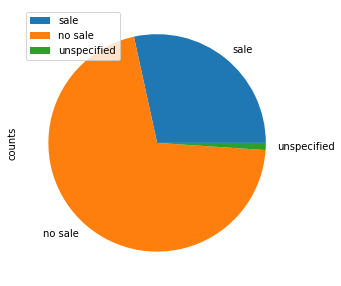

In [330]:
## Sale count of the 90 predicted policies

sale_count = (predictions_SVM_analyze == 'sale').sum()
print("number of sales:", sale_count)
no_sale_count = (predictions_SVM_analyze == 'no sale').sum()
print("number of no sales:", no_sale_count)
unspecified_count = (predictions_SVM_analyze == 'unspecified').sum()
print("number of unspecified:", unspecified_count)

print("percent of startups/mobile apps selling information:", sale_count/(sale_count+no_sale_count+unspecified_count))
print("percent of startups/mobile apps not selling information:", 
      no_sale_count/(sale_count+no_sale_count+unspecified_count))

counts = [sale_count, no_sale_count, unspecified_count]
labels = ['sale', 'no sale', 'unspecified']

df_counts = pd.DataFrame({'counts': counts},index=labels)
df_counts.plot.pie(y='counts',figsize=(5, 5))

number of sales: 26
number of no sales: 45
number of unspecified: 29


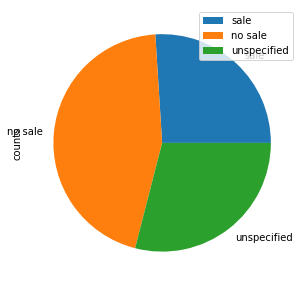

In [339]:
## Sale counts of the 100 annotated policies

sale_count = 26
print("number of sales:", sale_count)
no_sale_count = 45
print("number of no sales:", no_sale_count)
unspecified_count = 29
print("number of unspecified:", unspecified_count)

counts = [sale_count, no_sale_count, unspecified_count]
labels = ['sale', 'no sale', 'unspecified']

df_counts = pd.DataFrame({'counts': counts},index=labels)
df_counts.plot.pie(y='counts',figsize=(5, 5))

In [269]:
## Confusion & Classification report

from sklearn.metrics import classification_report, confusion_matrix
print ("confusion matrix \n", confusion_matrix(Test_Y, predictions_SVM), "\n\n")
print ("classification report \n", classification_report(Test_Y, predictions_SVM, digits=4))

confusion matrix 
 [[ 0  1  0  0]
 [ 0 13  3  0]
 [ 0  0  3  1]
 [ 0  3  2  1]] 


classification report 
               precision    recall  f1-score   support

                 0.0000    0.0000    0.0000         1
     no sale     0.7647    0.8125    0.7879        16
        sale     0.3750    0.7500    0.5000         4
 unspecified     0.5000    0.1667    0.2500         6

    accuracy                         0.6296        27
   macro avg     0.4099    0.4323    0.3845        27
weighted avg     0.6198    0.6296    0.5965        27



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
